In [ ]:
# !pip install transformers -q

In [2]:
from transformers import AutoTokenizer, TFRobertaModel,pipeline, AutoModel
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PLEASE COMMENT IF AFFTER DOWNLOADING
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
'''Trying out different models'''
# Pretrained on Clickbait corupus
# tokenizer = AutoTokenizer.from_pretrained("caush/Clickbait1",is_split_into_words=True)
# model = AutoModel.from_pretrained("caush/Clickbait1",output_hidden_states=True,output_attentions=True)

# Pretrained on Clickbait corupus
tokenizer = AutoTokenizer.from_pretrained("valurank/distilroberta-clickbait",is_split_into_words=True,add_prefix_space=True)
model = AutoModel.from_pretrained("valurank/distilroberta-clickbait",output_hidden_states=True,output_attentions=True)

# Not pretrained on clickbait corpus Roberta model
# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base",is_split_into_words=True,add_prefix_space=True)
# model = AutoModel.from_pretrained("FacebookAI/roberta-base",output_hidden_states=True,output_attentions=True)

model.eval()



tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at valurank/distilroberta-clickbait and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (drop

In [4]:
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    return filtered_tokens

def word_space_tokenizer(text):

    return text.split()

def predict(text):
  # Playing with different tokenizers
  tokens = tokenize_and_remove_stopwords(text)
  inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt")

  outputs = model(**inputs)
  tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
  print(tokens)
  attentions = outputs.attentions
  # print(attentions)

  layer_x = -2
  attention_layer_x = attentions[layer_x]

  # CLS token attention from layer X to X+1
  cls_attention = attention_layer_x[0, :, 0, :]
  avg_cls_attention_to_tokens = cls_attention.mean(dim=0)

  tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

  sorted_indices = torch.argsort(avg_cls_attention_to_tokens, descending=True)
  top_k = 10
  most_important = [(tokens[i], avg_cls_attention_to_tokens[i].item()) for i in sorted_indices[:top_k]]

  print("Most responsible words based on CLS attention:")
  for token, score in most_important:
      print(f"{token}: {score}")

  # avg attention plot
  plt.figure(figsize=(10, 6))
  plt.bar(range(len(tokens)), avg_cls_attention_to_tokens.detach().numpy())
  plt.xticks(range(len(tokens)), tokens, rotation=90)
  plt.xlabel("Tokens")
  plt.ylabel("Attention Weight")
  plt.title(f"CLS Token Attention (Layer {layer_x} to Layer {layer_x+1})")
  plt.tight_layout()
  plt.show()

# last_hidden_states = outputs.last_hidden_state

['<s>', 'ĠBest', 'Ġways', 'Ġmake', 'Ġmoney', 'Ġn', "'t", 'Ġwant', 'Ġknow', '</s>']
Most responsible words based on CLS attention:
<s>: 0.19969137012958527
ĠBest: 0.1518140286207199
Ġn: 0.11799939721822739
Ġknow: 0.11420627683401108
</s>: 0.10918694734573364
Ġways: 0.08199696987867355
Ġmake: 0.07792682200670242
Ġwant: 0.05580712854862213
't: 0.05511884018778801
Ġmoney: 0.0362522266805172


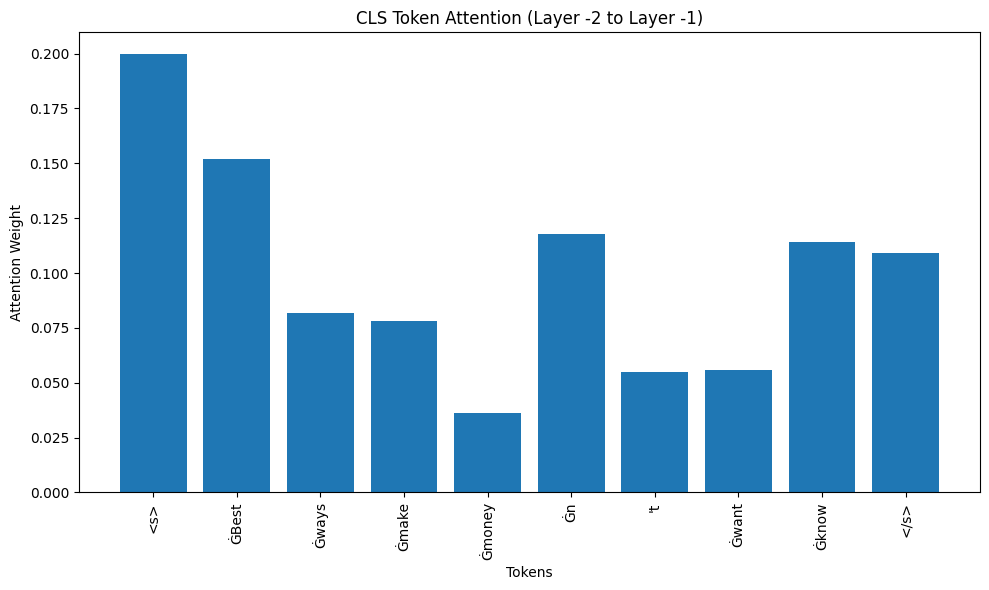

In [6]:
text = "How to choose the best college for you"
text = "An Open Letter to Jerry Seinfeld from a 'Politically Correct' College Student"
text = "Kids runs away from house to become the greatest Gamer of all time!"
text = "100 Fast ways to make quick quick"
text = "German killed by elephant"
text = "Wow, there are things that you can never put in the freezer!"
text = "How to increase your profit using the same content marketing strategy as Spotify?"
text = "Best ways to make money they don't want you to know"

predict(text)

Using the pretrained model on the Webis Clickbait data set